In [83]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
classNames = datasets.class_names
classNames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(datasets) # this is because every element in datasets is batch of 32

68

In [6]:
print("Inferred Class Names and their corresponding integer labels:")
for i, class_name in enumerate(classNames):
    print(f"{i}: {class_name}")

Inferred Class Names and their corresponding integer labels:
0: Potato___Early_blight
1: Potato___Late_blight
2: Potato___healthy


In [7]:
for image_batch , label_batch in datasets.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 2 0 0 2 0 0 0 0 1 0 0 0 1 2 1 0 0 0 0 1 0 1 1 2 0 0 0 1]


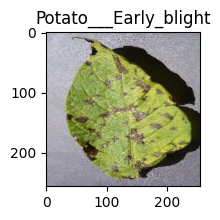

In [8]:
for image_batch , label_batch in datasets.take(1):
    plt.figure(figsize=(2, 2)) 
    plt.title(classNames[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

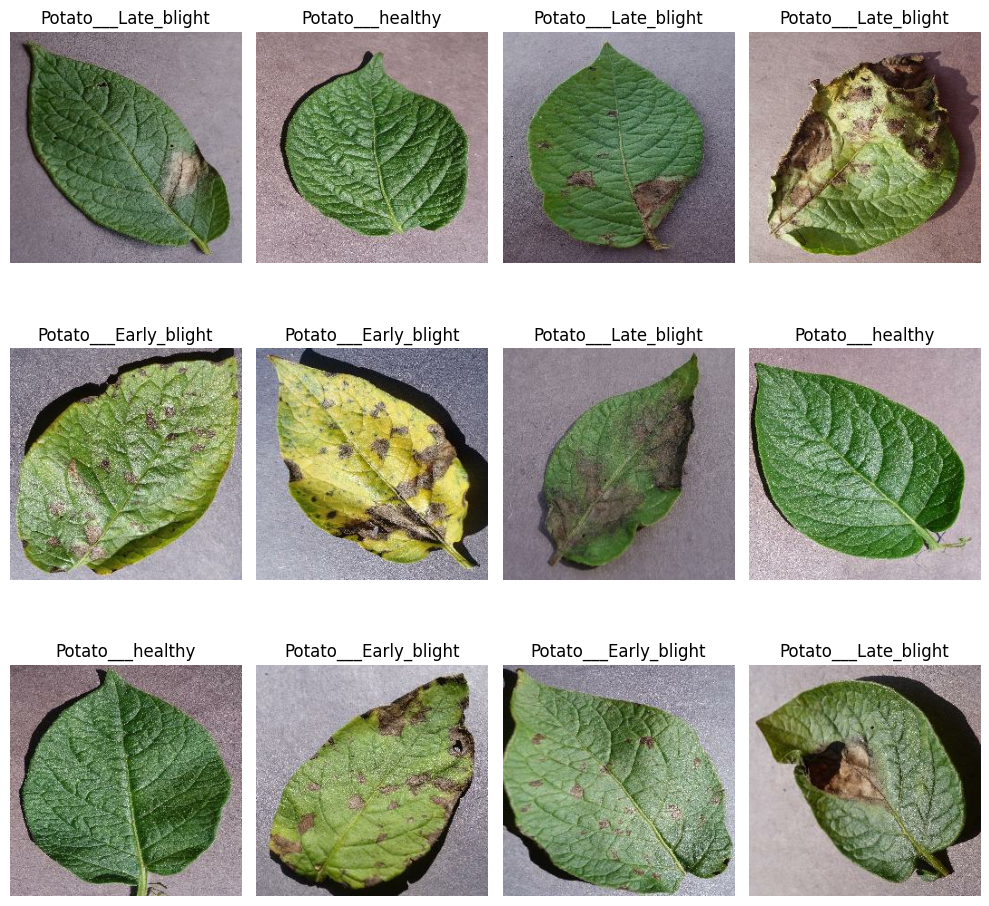

In [9]:
for image_batch, label_batch in datasets.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(12):
        plt.subplot(3, 4, i+1)
        
        current_image = image_batch[i].numpy().astype("uint8")
        current_label_integer = label_batch[i].numpy()
        current_class_name = classNames[current_label_integer]

        plt.imshow(current_image)
        plt.title(current_class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
# test and train datasets
# 80% ==> Train
# 20% ==> Test (10% for validation and 10% for test)
len(datasets)

68

In [11]:
train_size = 0.8
# calculate 80% of datasets
len(datasets)*train_size

54.400000000000006

In [12]:
train_datasets = datasets.take(54)
len(train_datasets)

54

In [13]:
remaining_datasets = datasets.skip(54)
len(remaining_datasets)

14

In [14]:
test_datasets = remaining_datasets.take(7)
validation_datasets = remaining_datasets.skip(7)

In [15]:
len(test_datasets)

7

In [16]:
len(validation_datasets)

7

In [17]:
# above are hard coded values so will write a function
def get_train_test_ds(ds , train_split = 0.8 , val_split = 0.1 , shuffle = True , shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed = 12)
    
    train_size = int(ds_size * train_split)
    train_ds = ds.take(train_size)

    val_size = int(ds_size * val_split)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds , test_ds , val_ds

In [18]:
train_ds , test_ds , val_ds = get_train_test_ds(datasets)

In [19]:
len(train_ds)

54

In [20]:
len(test_ds)

8

In [21]:
len(val_ds)

6

In [23]:
# caching and prefetching to optimize the datasets

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Removed .experimental.preprocessing
    keras.layers.Rescaling(1.0/255)                  # Removed .experimental.preprocessing
])

In [26]:
#applying data augmentation

data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
], name="data_augmentation")

In [29]:
# Model Building

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

model = keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4684 - loss: 0.9473
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - accuracy: 0.6021 - loss: 0.8141
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.7004 - loss: 0.6385
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.8213 - loss: 0.4067
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 400ms/step - accuracy: 0.8108 - loss: 0.4537
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.8638 - loss: 0.3355
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.8968 - loss: 0.2411
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.9082 - loss: 0.2224
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 378ms/step - accuracy: 0.9220 - loss: 0.1966
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.9453 - loss: 0.1576
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - accuracy: 0.8859 - loss: 0.2826
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23

In [40]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8277 - loss: 0.7314


In [42]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

In [44]:
acc = history.history['accuracy']
loss = history.history['loss']

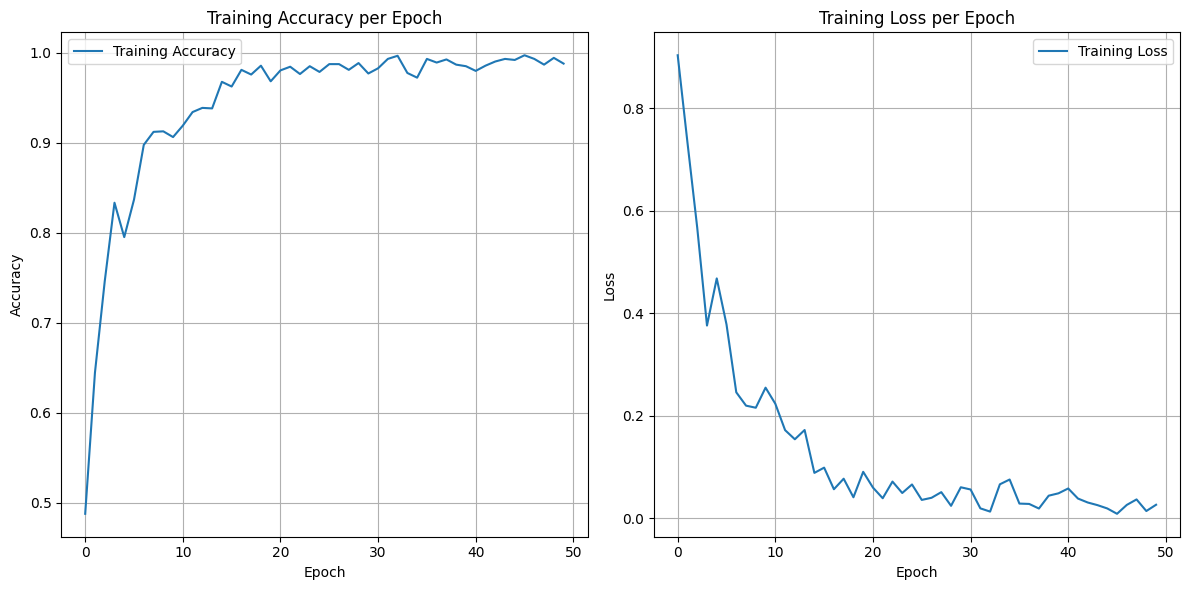

In [45]:

import matplotlib.pyplot as plt

# Create a range for the x-axis (epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()


In [ ]:
# so 25 epochs are enough as we can conclude using the above graph

First Image Prediction: 
First Image label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

First Image Prediction label:  Potato___Late_blight


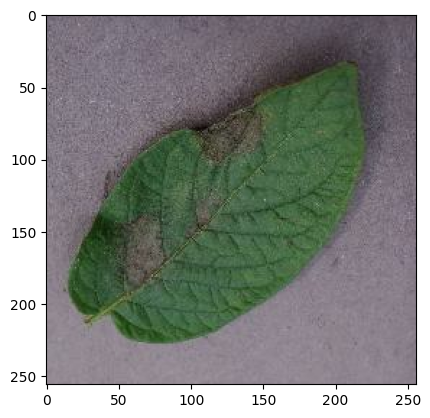

In [89]:
# let's predict
for image_batch , label_batch in test_ds.take(1):
     print("First Image Prediction: ")
     first_image = image_batch[0].numpy().astype("uint8")
     first_label = label_batch[0].numpy()
     print("First Image label: " , classNames[first_label])

     plt.imshow(first_image)

     model_prediction = model.predict(image_batch)
     first_image_predict = model_prediction[0]
     print("\nFirst Image Prediction label: " , classNames[np.argmax(first_image_predict)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


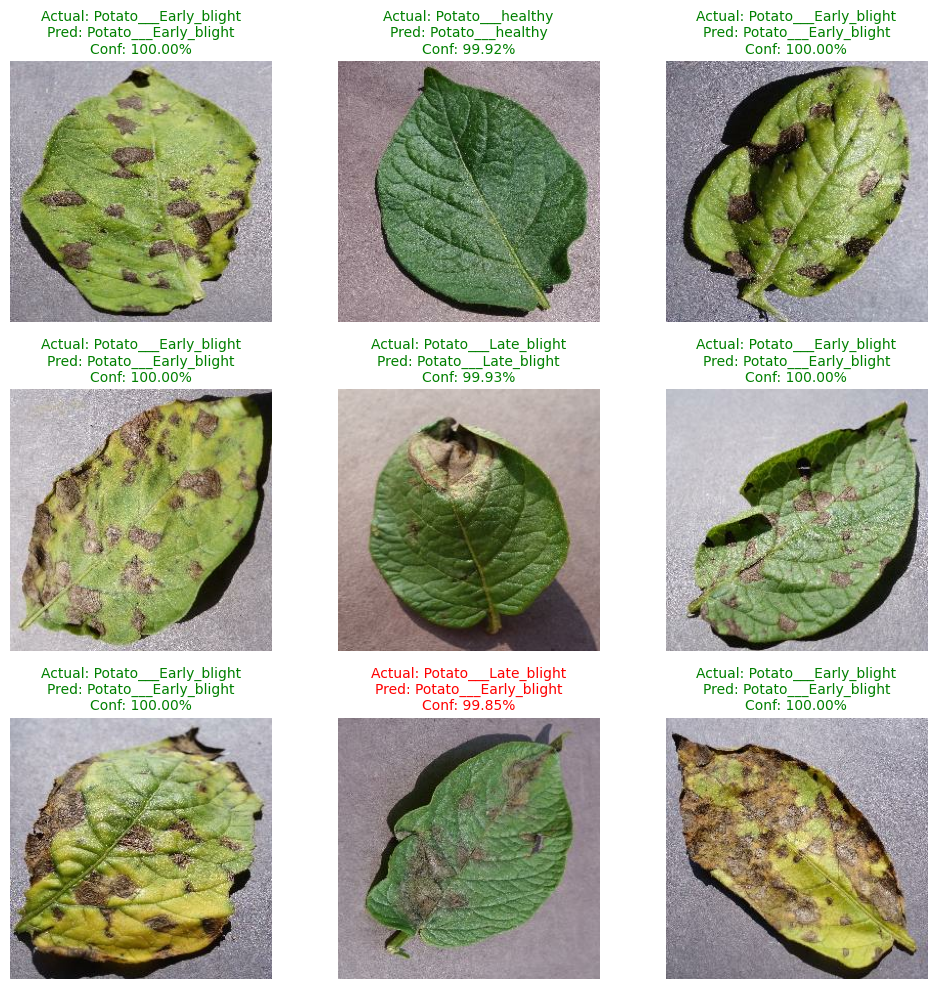

In [94]:

def predict_disease(model, image_batch, label_batch, class_names, num_images_to_predict=9):
   

    # Make predictions for the entire batch
    predictions = model.predict(image_batch)

    plt.figure(figsize=(10, 10)) # Adjust figure size for better visualization

    # Iterate through the first num_images_to_predict images
    for i in range(min(num_images_to_predict, image_batch.shape[0])): # Ensure we don't go out of bounds of the batch
        actual_label_index = label_batch[i].numpy()
        actual_label = class_names[actual_label_index]

        predicted_probabilities = predictions[i]
        predicted_label_index = np.argmax(predicted_probabilities)
        predicted_label = class_names[predicted_label_index]

        confidence = np.max(predicted_probabilities) * 100 # Get the confidence percentage

        # Plotting the image
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image_batch[i].numpy().astype("uint8")) 

        
        color = "green" if actual_label == predicted_label else "red"
        plt.title(f"Actual: {actual_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", color=color, fontsize=10)
        plt.axis("off") 

    plt.tight_layout()
    plt.show() 



for image_batch, label_batch in test_ds.take(1):
    predict_disease(model, image_batch, label_batch, classNames, num_images_to_predict=9)
    

In [96]:
# saving the model
import os

model_version = 1
# Ensure the directory exists
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True) # Creates the 'models' directory if it doesn't exist

model.save(f"{models_dir}/{model_version}.keras") # Added .keras extension
print(f"Model saved successfully to {models_dir}/{model_version}.keras")

Model saved successfully to ../models/1.keras
